# SV model with particle filter (WIP) - free params and proposal, hybrid optimization

In [1]:
import matplotlib.pyplot as plt
import torch
import ptvi

In [2]:
data_seed, algo_seed = 123, 123
params = dict(a=1., b=0., c=.95)
T = 200

In [3]:
model = ptvi.FilteredSVModelDualOpt(
    input_length=T, num_particles=8, resample=True)
model

Stochastic volatility model for dual optimization of model and proposal:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 200
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Particle filter with 8 particles, AR(1) proposal:
	z_t = d + e * z_{t-1} + η_t,  t=2, …, 200
	z_1 = d + 1/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [4]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

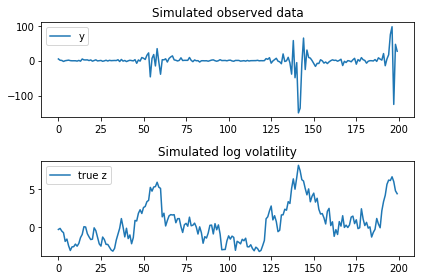

In [5]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [6]:
torch.manual_seed(algo_seed)
trace = ptvi.DualPointEstimateTracer(model)
fit = ptvi.sgvb_and_stoch_opt(model, y, tracer=trace, model_optimizer_type=torch.optim.Adam)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Alternating model/proposal structured SGVB Inference: Particle filtered stochastic volatility model
  - Using torch.float32 precision on cpu
  - Estimating elbo with M=1
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adam optimizer with param groups:
    group 0. lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed model elbo =-1166.91
       1. smoothed model elbo =-1134.37
       2. smoothed model elbo =-1121.41
       4. smoothed model elbo =-1378.82
       8. smoothed model elbo =-1735.68
      16. smoothed model elbo =-1599.87
      32. smoothed model elbo =-1250.89
      64. smoothed model elbo =-1637.69
     128. smoothed model elbo =-1381.70
     256. smoothed model elbo =-1100.27
     512. smoothed mo

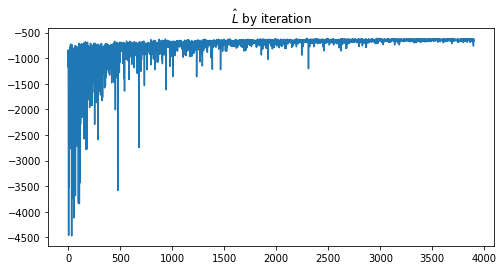

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
fit.plot_elbos()

In [8]:
fit.summary(true=params)

,mean,sd,true
a,1.011028,0.501016,1.00
b,0.225837,0.170782,0.00
c,0.854865,0.040088,0.95
d,0.383858,1.000000,NaN
e,0.904888,0.087232,NaN


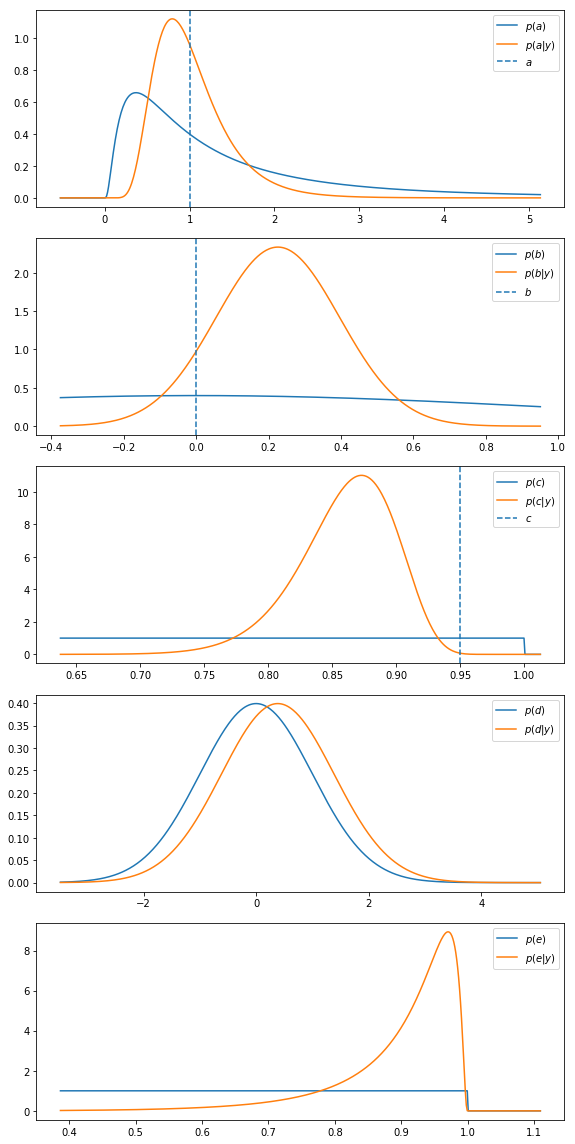

In [9]:
plt.rcParams['figure.figsize'] = [8, 16]
fit.plot_global_marginals(**params, cols=1)